<br><br><br><br><br><br>

### 3층 신경망


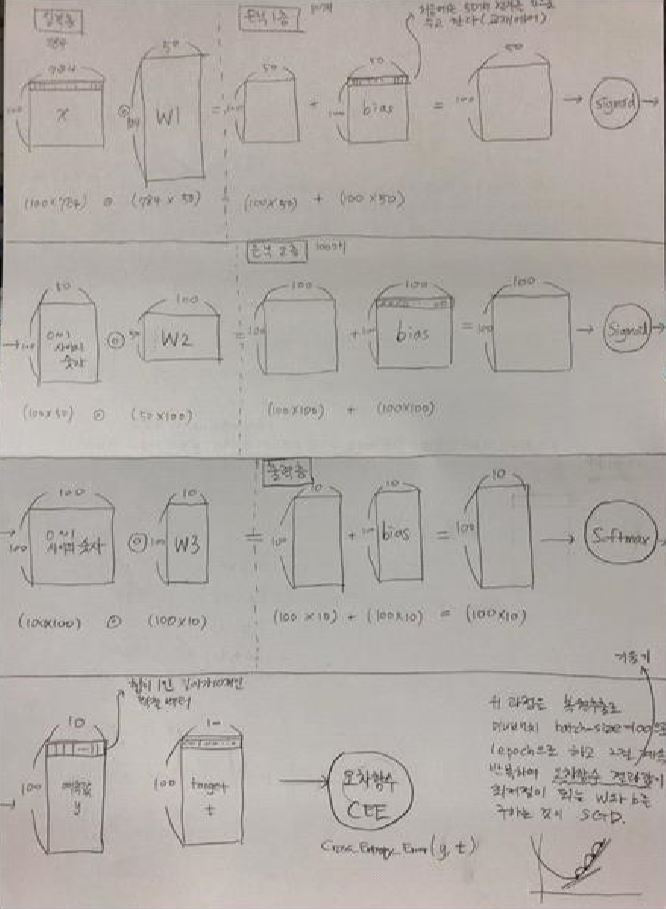

<br><br><br>

#### 수치미분을 이용한 2층 신경망 코드

In [2]:
# coding: utf-8 

import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정 

import numpy as np 
import matplotlib.pyplot as plt 
from dataset.mnist import load_mnist #from prac.common.functions import * #from prac.common.gradient import numerical_gradient


def sigmoid(x):  
    
    return 1 / (1 + np.exp(-x))


def softmax(a):   
    
    c = np.max(a)    
    exp_a = np.exp(a)    
    sum_exp_a = np.sum(exp_a)    
    y = exp_a / sum_exp_a    
    
    return y

def crossEntropyError(y, t):    
    
    delta = 1e-7 #아주 작은 값 (y가 0인 경우 -inf 값을 예방)   
    
    return -np.sum(t*np.log(y+delta)) / y.shape[0]

# def numerical_gradient(f,x): 
#     h = 1e-4 
#     grad = np.zeros_like(x) 
# 
#     for idx in range(x.size): 
#         tmp_val = x[idx] 
#         x[idx] = tmp_val + h 
#         fxh1 = f(x) # f(x+h) 를 계산 
# 
#         x[idx] = tmp_val - h 
#         fxh2 = f(x) # f(x-h) 를 계산 
# 
#         grad[idx] = (fxh1 - fxh2) / (2*h) 
#         x[idx]= tmp_val 
# 값 복원 
#
#     return grad

def numerical_gradient(f, x):    
    
    h = 1e-4  # 0.0001    
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])    
    
    while not it.finished:
        
        idx = it.multi_index        
        tmp_val = x[idx]        
        x[idx] = float(tmp_val) + h        
        fxh1 = f(x)  # f(x+h)
        x[idx] = tmp_val - h        
        fxh2 = f(x)  
        
        # f(x-h)        
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val  # 媛?蹂듭썝        
        it.iternext()
        
    return grad

class TwoLayerNet:    
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):        
        self.params = {}        
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)       
        self.params['b1'] = np.zeros(hidden_size)        
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)        
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):        
        W1, W2 = self.params['W1'], self.params['W2']        
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1        
        z1 = sigmoid(a1)        
        a2 = np.dot(z1, W2) + b2        
        y = softmax(a2)
        
        return y
    
    
    def loss(self, x,t): 
        
        y = self.predict(x)
        
        return crossEntropyError(y, t)
    
    
    def accuracy(self, x, t):
        
        y = self.predict(x)        
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])        
        
        return accuracy
    
    
    def numerical_gradient(self,x,t):        
        loss_W = lambda W: self.loss(x,t)
        
        grads = {}        
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])        
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])        
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])        
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
# 데이터 읽기 

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터 
iters_num = 10000  

# 반복 횟수를 적절히 설정한다. 
train_size = x_train.shape[0] 
batch_size = 100  

# 미니배치 크기 
learning_rate = 0.1
train_loss_list = [] 
train_acc_list = [] 
test_acc_list = []

# 1에폭당 반복 수 
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):    # 미니배치 획득    
    batch_mask = np.random.choice(train_size, batch_size)    
    x_batch = x_train[batch_mask]    
    t_batch = t_train[batch_mask]
    
    # 기울기 계산    
    grad = network.numerical_gradient(x_batch, t_batch)    
    #grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신    
    for key in ('W1', 'b1', 'W2', 'b2'):        
        network.params[key] -= learning_rate * grad[key]
        
    # 학습 경과 기록    
    loss = network.loss(x_batch, t_batch)    
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산    
    if i % iter_per_epoch == 0:        
        train_acc = network.accuracy(x_train, t_train)        
        test_acc = network.accuracy(x_test, t_test)        
        train_acc_list.append(train_acc)        
        test_acc_list.append(test_acc)        
        
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
    
    
# # 그래프 그리기 
# markers = {'train': 'o', 'test': 's'} 
# x = np.arange(len(train_acc_list)) 
# plt.plot(x, train_acc_list, label='train acc') 
# plt.plot(x, test_acc_list, label='test acc', linestyle='--') 
# plt.xlabel("epochs") 
# plt.ylabel("accuracy") 
# plt.ylim(0, 1.0) 
# plt.legend(loc='lower right') 
# plt.show()


<br><br><br><br><br>

#### 위의 코드 분해해서 이해

<br><br><br><br>

##### 문제 56)  TwoLayerNet 클래스로 객체를 생성하고 W1, W2, b1, b2 의 행렬의 모양을 확인하시오


In [3]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10) 

print('w1',network.params.get('W1').shape) 
print('w2',network.params.get('W2').shape) 
print('b1',network.params.get('b1').shape)
print('b1',network.params.get('b1').shape) 
print('b2',network.params.get('b2').shape)


w1 (784, 50)
w2 (50, 10)
b1 (50,)
b1 (50,)
b2 (10,)


<br><br><br><br><br>

###### 문제 57)  TwoLayerNet 클래스의 객체를 생성하고 predict 메소드를 실행하여 나온 결과의 행렬의 shape를 출력하시오 


In [4]:
# 데이터 읽기 
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True) 
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10) 
network.predict(x_train)[:100].shape

(100, 10)

<br><br><br><br><br>

###### 문제 58)  TwoLayerNet 클래스의 객체를 생성하고 crossEntropyError(y, t) 메소드를 실행해서 나온 출력결과인 오차를 출력하시오.

In [5]:
# 데이터 읽기 

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True) 
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10) 
y = network.predict(x_train)[:100] 
t = t_train[:100] 

print('오차:', crossEntropyError(y, t))

오차: 13.252206872733241


<br><br><br><br><br><br>

#### accuracy 함수의 이해

예상한 숫자와 실제 숫자를 비교해서 정확도를 출력하는 함수
 

<br><br><br>

##### 문제 59)  TwoLayerNet 클래스로 객체를 생성하고 accuracy(x, t) 메소드를 실행해서 100장 훈련데이터와 100장의 target 데이터를 입력했을 때의 정확도를 출력하시오
 

In [7]:
# 데이터 읽기 
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True) 
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10) 
y = x_train[:100] 
t = t_train[:100] 
print('오차:', network.loss(y, t))

# 정확도
print('정확도:', network.accuracy(y, t))


오차: 6.909693290484333
정확도: 0.08


<br><br><br><br><br>

#### numerical_gradient 함수 

비용함수와 가중치 또는 Bias를 입력받아 기울기를 출력하는 함수

비용함수 생성 방법

In [8]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10) 

def f(W):    
    return network.loss(x, t)

설명) <br>여기서 정의한 f(W) 함수의 W는 더미로 만든 것입니다.<br> numerical_gradien(f, x) 내부에서 f(x)를 실행하는데 그와의 일관성을 위해서 f(W)를 정의한 것


In [ ]:
# coding: utf-8 
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정 
import numpy as np 
import matplotlib.pyplot as plt 
from dataset.mnist import load_mnist 
#from common.functions import * 

#from common.gradient import numerical_gradient
def sigmoid(x):    
    return 1 / (1 + np.exp(-x))

def softmax(a):   
    c = np.max(a)    
    exp_a = np.exp(a)    
    sum_exp_a = np.sum(exp_a)    
    y = exp_a / sum_exp_a    
    return y

def crossEntropyError(y, t):    
    delta = 1e-7 #아주 작은 값 (y가 0인 경우 -inf 값을 예방)    
    return -np.sum(t*np.log(y+delta)) / y.shape[0]

# def numerical_gradient(f,x): 
#     h = 1e-4 
#     grad = np.zeros_like(x) 
# 
#     for idx in range(x.size): 
#         tmp_val = x[idx] 
#         x[idx] = tmp_val + h 
#         fxh1 = f(x) # f(x+h) 를 계산 
#
#         x[idx] = tmp_val - h 
#         fxh2 = f(x) # f(x-h) 를 계산 
# 
#         grad[idx] = (fxh1 - fxh2) / (2*h) 
#         x[idx]= tmp_val # 값 복원 
# 
#     return grad

def numerical_gradient(f, x):    
    h = 1e-4  # 0.0001    
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])    
    
    while not it.finished:        
        idx = it.multi_index 
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h        
        fxh1 = f(x)  
        
        # f(x+h)
        x[idx] = tmp_val - h        
        fxh2 = f(x) 
        
        # f(x-h)        
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val  # 媛?蹂듭썝        
        it.iternext()
        
    return grad

class TwoLayerNet:    
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):        
        self.params = {}        
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)       
        self.params['b1'] = np.zeros(hidden_size)        
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)        
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):        
        W1, W2 = self.params['W1'], self.params['W2']        
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1        
        z1 = sigmoid(a1)        
        a2 = np.dot(z1, W2) + b2        
        y = softmax(a2)
        
        return y
    
    
    def loss(self, x,t): 
        
        y = self.predict(x)
        
        return crossEntropyError(y, t)
    
    
    def accuracy(self, x, t):
        
        y = self.predict(x)        
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])        
        
        return accuracy
    
    
    def numerical_gradient(self,x,t):        
        loss_W = lambda W: self.loss(x,t)
        
        grads = {}        
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])        
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])        
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])        
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    
# 데이터 읽기 

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

print(network.loss(x_train[:100], t_train[:100]))


# 하이퍼파라미터 

iters_num = 10000  

# 반복 횟수를 적절히 설정한다. 

train_size = x_train.shape[0] 
batch_size = 100  

# 미니배치 크기 

learning_rate = 0.1
train_loss_list = [] 
train_acc_list = [] 
test_acc_list = []

# 1에폭당 반복 수 

iter_per_epoch = max(train_size / batch_size, 1)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
(x_train, t_train) , (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
x = x_train[:100] 
t = t_train[:100]


def f(W):    
    return  network.loss(x,t)

W1_grad = numerical_gradient( f, network.params.get('W1') )

print (W1_grad)


<br><br><br><br><br>

#### lambda 표현식 이란?


In [ ]:
# coding: utf-8 
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정 
import numpy as np 
import matplotlib.pyplot as plt 
from dataset.mnist import load_mnist 
#from common.functions import * 

#from common.gradient import numerical_gradient
def sigmoid(x):    
    return 1 / (1 + np.exp(-x))

def softmax(a):   
    c = np.max(a)    
    exp_a = np.exp(a)    
    sum_exp_a = np.sum(exp_a)    
    y = exp_a / sum_exp_a    
    return y

def crossEntropyError(y, t):    
    delta = 1e-7 #아주 작은 값 (y가 0인 경우 -inf 값을 예방)    
    return -np.sum(t*np.log(y+delta)) / y.shape[0]

# def numerical_gradient(f,x): 
#     h = 1e-4 
#     grad = np.zeros_like(x) 
# 
#     for idx in range(x.size): 
#         tmp_val = x[idx] 
#         x[idx] = tmp_val + h 
#         fxh1 = f(x) # f(x+h) 를 계산 
#
#         x[idx] = tmp_val - h 
#         fxh2 = f(x) # f(x-h) 를 계산 
# 
#         grad[idx] = (fxh1 - fxh2) / (2*h) 
#         x[idx]= tmp_val # 값 복원 
# 
#     return grad

def numerical_gradient(f, x):    
    h = 1e-4  # 0.0001    
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])    
    
    while not it.finished:        
        idx = it.multi_index 
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h        
        fxh1 = f(x)  
        
        # f(x+h)
        x[idx] = tmp_val - h        
        fxh2 = f(x) 
        
        # f(x-h)        
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val  # 媛?蹂듭썝        
        it.iternext()
        
    return grad

class TwoLayerNet:    
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):        
        self.params = {}        
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)       
        self.params['b1'] = np.zeros(hidden_size)        
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)        
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):        
        W1, W2 = self.params['W1'], self.params['W2']        
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1        
        z1 = sigmoid(a1)        
        a2 = np.dot(z1, W2) + b2        
        y = softmax(a2)
        
        return y
    
    
    def loss(self, x,t): 
        
        y = self.predict(x)
        
        return crossEntropyError(y, t)
    
    
    def accuracy(self, x, t):
        
        y = self.predict(x)        
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])        
        
        return accuracy
    
    
    def numerical_gradient(self,x,t):        
        loss_W = lambda W: self.loss(x,t)
        
        grads = {}        
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])        
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])        
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])        
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    
# 데이터 읽기 

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

print(network.loss(x_train[:100], t_train[:100]))


# 하이퍼파라미터 

iters_num = 10000  # 반복 횟수를 적절히 설정한다. 

train_size = x_train.shape[0] 
batch_size = 100  #미니배치 크기 

learning_rate = 0.1

train_loss_list = [] 
train_acc_list = [] 
test_acc_list = []

# 1에폭당 반복 수 

iter_per_epoch = max(train_size / batch_size, 1)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

(x_train, t_train) , (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

x = x_train[:100] 
t = t_train[:100]


def f(W):    
    return  network.loss(x,t)

W1_grad = numerical_gradient( f, network.params.get('W1') )

print (W1_grad)


<br><br><br><br><br>

##### 문제 60) 아래의 비용함수를 lambda 표현식으로 한줄로 변경해서 출력하시오


보기) <br>def f(W):   <br>
　　return  network.loss(x,t)


In [14]:
f = lambda W: network.loss(x,t)

<br><br><br><br><br>

##### 문제 61)  TwoLayerNet 클래스를 가지고 학습 시키는 코드를 완성시키시오


In [ ]:
# 데이터 읽기 

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)



# 하이퍼파라미터 

iters_num = 10000  # 반복 횟수를 적절히 설정한다. 

train_size = x_train.shape[0]   # x_train : (60000, 784) 
batch_size = 100  #미니배치 크기 

learning_rate = 0.1

#그래프 그릴떄 필요한 데이터를 담을 리스트 변수 3개를 선언
train_loss_list = []  # 훈련데이터의 손실 
train_acc_list = []  # 훈련데이터의 정확도 
test_acc_list = []    # 테스트 데이터의 정확도

# 1에폭당 반복 수 

iter_per_epoch = max(train_size / batch_size, 1)
# 60000 / 100 = 600 => max(600, 1) = 600


for i in range(iters_num):    
    # 미니배치 획득  # 랜덤으로 100개 씩 뽑는 작업을 10000번 수행    
    batch_mask = np.random.choice(train_size, batch_size)    
    # 0 ~ 60000 의 숫자 중에 100개를 랜덤으로 생성    
    x_batch = x_train[batch_mask]    
    t_batch = t_train[batch_mask]
    
    # 기울기 계산    
    grad = network.numerical_gradient(x_batch, t_batch)    
    #grad = network.gradient(x_batch, t_batch)      
    # 오차역전파를 이용한 기울기 구하는 함수 (빠름, 나중에 배울 예정)
    
    # 매개변수 갱신    
    for key in ('W1', 'b1', 'W2', 'b2'):        
        network.params[key] -= learning_rate * grad[key]
        
    # 학습 경과 기록   # 손실(비용)이 점점 줄어드는 것을 보기 위해    
    loss = network.loss(x_batch, t_batch)    
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산    
    if i % iter_per_epoch == 0:   # 600/600, 1200/600, 1800/600 ...       
        train_acc = network.accuracy(x_train, t_train)        
        test_acc = network.accuracy(x_test, t_test)       
        train_acc_list.append(train_acc)        
        test_acc_list.append(test_acc)        
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


<br><br><br><br><br>

##### 문제 62)   수치미분이 아닌 오차 역전파를 이용한 신경망 학습으로 2층 신경망 코드를 구현하시오


train acc, test acc | 0.09138333333333333, 0.0909
train acc, test acc | 0.9048666666666667, 0.907
train acc, test acc | 0.9229333333333334, 0.9249
train acc, test acc | 0.9336166666666667, 0.9334
train acc, test acc | 0.9435833333333333, 0.9427
train acc, test acc | 0.9499, 0.9477
train acc, test acc | 0.9554333333333334, 0.9523
train acc, test acc | 0.9609, 0.9589
train acc, test acc | 0.9637, 0.962
train acc, test acc | 0.9676833333333333, 0.9647
train acc, test acc | 0.9702333333333333, 0.9675
train acc, test acc | 0.9719833333333333, 0.9693
train acc, test acc | 0.97315, 0.9681
train acc, test acc | 0.9744833333333334, 0.968
train acc, test acc | 0.9771166666666666, 0.9705
train acc, test acc | 0.9768833333333333, 0.9697
train acc, test acc | 0.97855, 0.9712


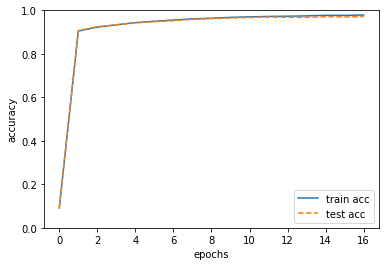

In [5]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: 
            t = np.argmax(t, axis=1)
            accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            # 결과 저장
            grads = {}
            grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
            grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grads
    
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000 # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100 # 미니배치 크기
learning_rate = 0.1
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)
for i in range(iters_num): # 10000
    # 미니배치 획득 # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 기울기 계산
    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) # cost 가 점점 줄어드는것을 보려고
    
    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.
        
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개 16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc) # 10000/600 개 16개 # 정확도가 점점 올라감
        
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

<br><br><br><br><br>

## 오차역전파

### 역전파란? <br><br>
신경망 학습 처리에서 최소화되는 함수의 경사를 효율적으로 계산하기 위한 방법으로 "오류 역전파" 가 있다<br><br>
비용함수의기울기를계산하는방법<br><br> 1. 수치미분<br> 2. 오류역전파<br><br>
#### 오차역전파란? <br>
순전파 : 입력층 → 은닉층 → 출력층 <br>역전파 : 입력층 ← 은닉층 ← 출력층<br><br><br>
여기서 역전파를 시키는 것이 오류(오차) 입니다<br><br>
출력층부터 차례대로 역방향으로 따라 올라가 각 층에 있는 노드의 오차를 계산할 수 있다.<br> 각 노드의 오차를 계산하면 그 오차를 사용해서 함수의 기울기를 계산할 수 있다.<br><br>
"즉 전파된 오차를 이용해서 가중치를 조정한다"<br>　　　　↓      <br> "오류(오차) 역전파"<br><br>

#### 계산그래프 <br>
순전파와 역전파에 계산 과정을 그래프로 나타내는 방법<br><br>

##### 계산그래프의 장점 <br> 
국소적 계산이 가능하다.<br><br>
국소적 계산이란 전체에 어떤 일이 벌어지든 상관없이 자신과 관계된 정보만으로 다음 결과를 출력 할 수 있다는 것이다.



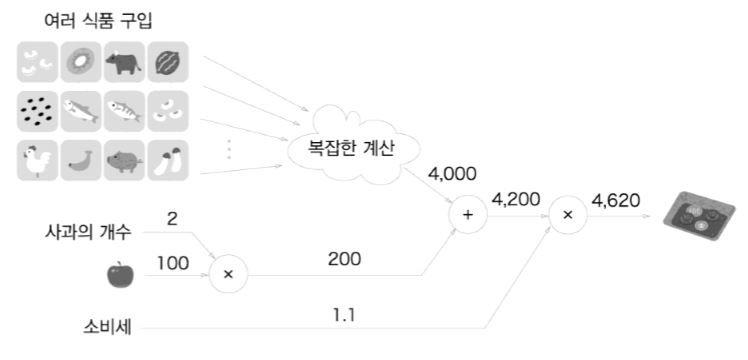

4000원 이라는 숫자가 어떻게 계산되었느냐와는 상관없이 사과가 어떻게 200원이 되었는가만 신경 쓰면 된다는 것이 국소적 계산이다


왜 계산 그래프로 문제를 해결 하는가? <br>전체가 아무리 복잡해도 각 노드에서 단순한 계산에 집중하여 문제를 단순화 시킬 수 있다.<br> (수치미분으로 하면 오~~~래 걸리기 때문에)<br><br>
실제로 계산 그래프를 사용하는 가장 큰 이유는?<br> 역전파를 통해서 미분을 효율적으로 계산할 수 있는 점에 있다<br>
예)<br> 사과값이 '아주 조금' 올랐을때 '지불금액'이 얼마나 증가하는지 알고 싶은 경우<br><br>
∂ 지불금액<br> ------------<br>∂ 사과값<br><br>
지불금액을 사과값으로 편미분하면 알 수 있다<br>
편미분하는 방법 : 계산 그래프로 역전파를 이용한다<br>
결과 : 사과값이 1원이 오르면 최종 금액은 2.2원이 오른다

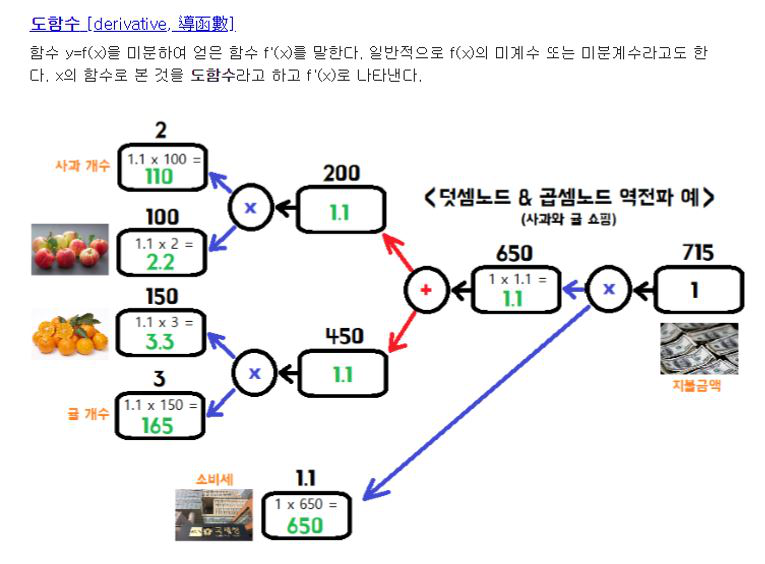

<br><br><br><br>

#### 문제 63) 곱셈계층을 파이썬으로 구현하시오


In [9]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out
    
    def backward(self, dout):
        dx = dout * self.y # x와 y를 바꾼다
        dy = dout * self.x
        return dx, dy
    
apple = 100
apple_num = 2
tax = 1.1
# 계층들
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()
# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)
print(price)

220.00000000000003


<br><br><br><br>

##### 문제64) 덧셈으로 파이썬구현

In [10]:
class AddLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1 
        dy = dout * 1
        return dx, dy

<br><br><br><br><br>

### 활성화함수 계층 구현하기

<br><br><br>

#### Relu 계층

" 0보다 큰 값이 입력되면 그 값을 그대로 출력하고 0 이거나 0보다 작은 값이 입력되면 0을 출력하 는 함수 "


<br><br>

##### 문제 65)  Relu 클래스를 생성하시오

In [11]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0) # x 에서 0보다 작은 값들에 True 들어감
        out = x.copy()
        out[self.mask] = 0 # out 에서 0보다 작은 값들 0 으로 바꿔줌

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

<br><br><br>

#### Sigmoid 계층

<br><br>

##### 문제 66) sigmoid 클래스를 생성하시오.

In [12]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out

        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

<br><br><br><br>

### Affine/Softmax 계층 구현하기

#### Affine 계층

신경망의 순전파 때 수행하는 행령의 내적은 기하학에서는 어파인 변환 이라고합니다.

그래서 신경망에서 입력값과 가중치의 내적의 합에 바이어스를 더하는 그 층을 Affine 계층이라고 한다.

지금까지의 계산그래프는 노드 사이에 '스칼라값' 이 흘렀는데 이에 반해 이번에는 '행렬' 이 흐르고있다


###### 문제 67) 위의 순전파의 역전파된 최종값인 dX와 dW를 각각 구하시오

In [13]:
import numpy as np
X = np.array([[1,2]])
W = np.array([[1,3,5], [2,4,6]])
b = np.array([[1,2,3]])
X_W_dot = np.dot(X, W)
print('X dot Y:', X_W_dot)
Y = X_W_dot + b
print('Y:', Y)
dY = np.array([[1,2,3]])
dX = np.dot(dY, W.T)
print('dX:', dX)
dW = np.dot(X.T, dY)
print('dW:', dW)

X dot Y: [[ 5 11 17]]
Y: [[ 6 13 20]]
dX: [[22 28]]
dW: [[1 2 3]
 [2 4 6]]


<br>

##### 문제 68) 아래의 행렬을 입력받아 결과를 출력하는 forward 함수를 생성하시오

In [14]:
def forward(X, W, b):
    out = np.dot(X, W) + b
    return out

print(forward(X, W, b))

[[ 6 13 20]]


In [15]:
def backward(X, W, dY):
    dX = np.dot(dY, W.T)
    print('dX(입력값에 대한 역전파):\n', dX)
    dW = np.dot(X.T, dY)
    print('dW(가중치에 대한 역전파):\n', dW)
    
X = np.array([[1,2], [3,4]]) # (2, 2)
W = np.array([[1,3,5], [2,4,6]]) # (2, 3)
b = np.array([[1,1,1]]) # (1, 3)
dY = np.array([[1,1,1], [2,2,2]]) # (2, 3)

backward(X, W, dY)

dX(입력값에 대한 역전파):
 [[ 9 12]
 [18 24]]
dW(가중치에 대한 역전파):
 [[ 7  7  7]
 [10 10 10]]


<br>

##### 문제 69)  Affine 클래스를 구현하시오

In [19]:
X = np.array([[1,2], [3,4]]) # (2, 2)
W = np.array([[1,3,5], [2,4,6]]) # (2, 3)
b = np.array([[1,1,1]])      # (1, 3)
dY = np.array([[1,1,1], [2,2,2]]) # (2, 3)

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    # 순전파
    def forward(self, x):
        self.x = x
        Y = np.dot(x, self.W) + self.b

        return Y
    # 역전파
    def backward(self, dY):
        dx = np.dot(dY, self.W.T)
        self.dW = np.dot(X.T, dY)
        self.db = np.sum(dY, axis=0)

        return dx

affine1 = Affine(W, b) # 가중치와 바이어스로 신경망 객체 affine1을 생성한 것
print(affine1.forward(X))
print(affine1.backward(dY))

[[ 6 12 18]
 [12 26 40]]
[[ 9 12]
 [18 24]]


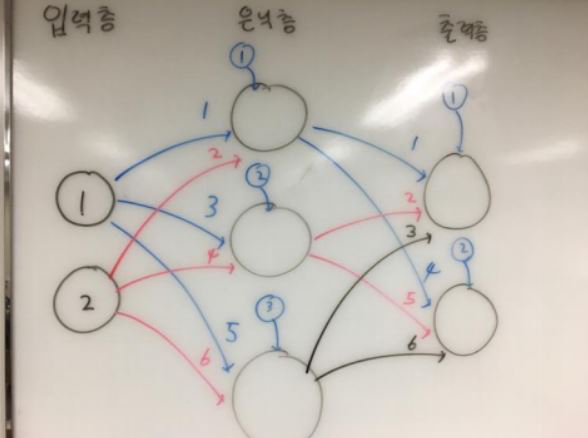

<br><br><br>

###### 문제 70) Affine 클래스를 이용해서 2층 신경망의 순전파를 구현하시오

In [22]:
x = np.array([[1,2]]) # (1, 2)
W1 = np.array([[1,3,5], [2,4,6]]) # (2, 3)
W2 = np.array([[1,4], [2,5], [3,6]]) # (3, 2)
b1 = np.array([[1,2,3]]) # (1, 3)
b2 = np.array([[1,2]]) # (1, 2)

layer_1 = Affine(W1, b1)
layer_2 = Affine(W2, b2)
out1 = layer_1.forward(x)
out2 = layer_2.forward(out1)
print(out2)

[[ 93 211]]


<br>

## 소프트 맥스 함수 계산 그래프

### Softmax 계층의 계산 그래프 (순전파만)

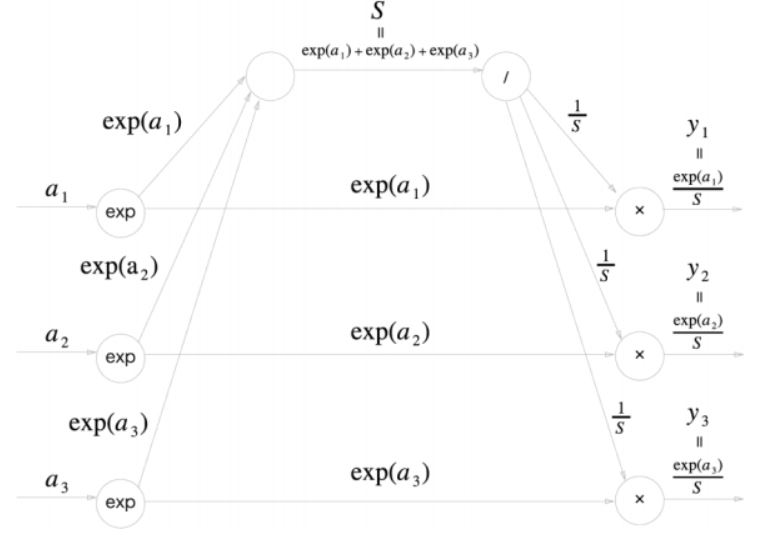

<br><br>

### Cross Entropy Error 게층의 계산 그래프 (순전파만)


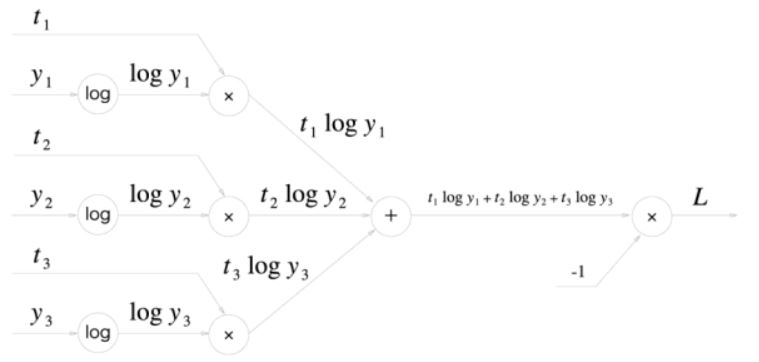

<br><br>

##### 문제 71)  class SoftmaxWithLoss 함수를 구현하시오

In [25]:
def softmax(a):
    c = np.max(a)
    minus = a - c
    np_exp = np.exp(minus)
    return np_exp

def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y+delta))

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실
        self.y = None # softmax의 출력
        self.t = None # 정답 레이블 (원-핫 벡터)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx

<br><br>

##### 문제 72)   위에서 만든 SoftmaxWithLoss 클래스를 객체화 시켜서 아래의 x(입력값), t(target value)를 입력해서 순전파의 오차율을 출력하고 역전파도 출력하시오

In [26]:
t = np.array([0,0,1,0,0,0,0,0,0,0]) # 숫자 2
x1 = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.05, 0.3, 0.1, 0.5])
x2 = np.array([0.01, 0.01, 0.9, 0.01, 0.01, 0.01, 0.05, 0.3, 0.1, 0.02])

soft_with_loss1 = SoftmaxWithLoss()
print(soft_with_loss1.forward(x2, t))
print(soft_with_loss1.backward())

-9.999999505838704e-08
[0.04106558 0.04106558 0.         0.04106558 0.04106558 0.04106558
 0.04274149 0.05488116 0.0449329  0.04147829]


<br><br><br><br>

### OrderDict() 함수의 이해<br><br>

OrderDict은 그냥 dictionary와는 다르게 입력된 데이터 뿐만 아니라 입력된 순서까지 같아야 동일 한 것으로 판단한다

In [27]:
# 예제
import collections
print('dict:')
d1 = {}
d1['a'] = 'A'
d1['b'] = 'B'
d1['c'] = 'C'
d1['d'] = 'D'
d1['e'] = 'E'
d2 = {}
d2['e'] = 'E'
d2['d'] = 'D'
d2['c'] = 'C'
d2['b'] = 'B'
d2['a'] = 'A'
print(d1)
print(d2)
print(d1 == d2)

dict:
{'a': 'A', 'b': 'B', 'c': 'C', 'd': 'D', 'e': 'E'}
{'e': 'E', 'd': 'D', 'c': 'C', 'b': 'B', 'a': 'A'}
True


   순전파 순서의 반대로 역전파가 되어야 하기 때문에 orderedDict 함수를 사용해야 한다
    
    순전파 :
    입력값 --> Affine1 계층 --> 시그모이드 --> Affine2 계층 --> 소프트맥스
    
    역전파:
    소프트맥스 --> Affine2 계층 --> 시그모이드 --> Affine1 계층

<br><br><br><br>

### 오차역전파를 이용한 2층 신경망 전체 코드<br><br>

클래스 이름: TwoLayerNet
1. 가중치와 바이어스를 초기화 하는 함수 (__init__)
2. 순전파를 진행하는 함수 (predict)
3. 비용(오차) 를 출력하는 함수 (loss)
4. 정확도를 출력하는 함수 (accuracy)
5. 오차역전파를 진행하는 함수 (gradient) <br><br><br><br>


##### 문제 73) 책 181~183페이지에 나오는 클래스 생성하시오 (점심시간 문제)

In [ ]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])


        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : 
            t = np.argmax(t, axis=1)
            accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads

    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads
    
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label = True)
network = TwoLayerNet(input_size = 784, hidden_size_1 = 50, hidden_size_2 = 100, output_size= 10)
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            test_acc = network.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            print(train_acc, test_acc)

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

    0.11805 0.1077
    0.8671166666666666 0.8732
    0.9168333333333333 0.9168
    0.9387 0.9373
    0.9517 0.9495
    0.9577666666666667 0.954
    0.96065 0.9575
    0.9692833333333334 0.9618
    0.9645333333333334 0.9577
    0.9747 0.9656
    0.9776333333333334 0.9667
    0.9771666666666666 0.9663
    0.9777833333333333 0.9664
    0.9814 0.9691
    0.9838666666666667 0.969
    0.9846333333333334 0.9685
    0.9849833333333333 0.9695

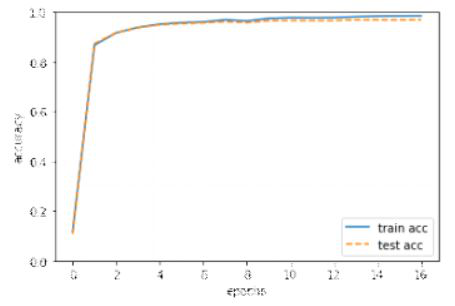